# Libraries

In [115]:
import pandas as pd
import glob
import requests
import time

In [116]:
import matplotlib.pyplot as plt

In [117]:
import seaborn as sns

In [118]:
from scipy.stats import pearsonr

In [144]:
import pytz

# Data Loading

In [192]:
# load the streaming history data, where 'ts' column is datetime
stream_df = pd.read_csv('datasets/tracks_df_processed.csv', parse_dates=['ts'])

C:\Users\Kim\AppData\Local\Temp\ipykernel_12008\2479707888.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  stream_df = pd.read_csv('datasets/tracks_df_processed.csv', parse_dates=['ts'])


In [193]:
stream_df[['ts', 'ts_local', 'conn_country']].sample(5)

,ts,ts_local,conn_country
118868,2023-06-02 16:52:54+00:00,2023-06-03 00:52:54+08:00,SG
79756,2021-07-14 07:45:44+00:00,2021-07-14 16:45:44+09:00,JP
18595,2018-01-23 02:35:52+00:00,2018-01-23 09:35:52+07:00,ID
11611,2017-09-28 20:17:00+00:00,2017-09-29 03:17:00+07:00,ID
63497,2020-08-08 23:50:29+00:00,2020-08-09 08:50:29+09:00,JP


In [173]:
stream_df.dtypes

ts                datetime64[ns, UTC]
platform                       object
ms_played                       int64
conn_country                   object
track_name                     object
artist_name                    object
album_name                     object
track_id                       object
reason_start                   object
reason_end                     object
shuffle                         int64
skipped                        object
offline                         int64
incognito_mode                  int64
ts_local                       object
dtype: object

In [155]:
#check the number of rows and columns we have in streaming_df
print(stream_df.shape)
print(stream_df.columns)

(129393, 15)
Index(['ts', 'platform', 'ms_played', 'conn_country', 'track_name',
       'artist_name', 'album_name', 'track_id', 'reason_start', 'reason_end',
       'shuffle', 'skipped', 'offline', 'incognito_mode', 'ts_local'],
      dtype='object')


In [156]:
# load the track info data
track_info_df = pd.read_csv('datasets/tracks_info_df.csv')

In [157]:
print(track_info_df.shape)
print(track_info_df.columns)

(5245, 6)
Index(['track_id', 'name', 'artistName', 'release_date', 'popularity',
       'duration_ms'],
      dtype='object')


In [158]:
# load the track features data
track_features_df = pd.read_csv('datasets/tracks_features_df.csv')

In [159]:
print(track_features_df.shape)
print(track_features_df.columns)

(5238, 13)
Index(['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')


# Analysing trends of the data

first, we need to extract year, month, date, day of week and time of day (hour) from ts_local for the analysis.

In [194]:
def extract_info(dt_str):
    dt = pd.to_datetime(dt_str, format='%Y-%m-%d %H:%M:%S%z')  # Explicitly parse with timezone
    
    year = dt.year
    month = dt.month
    day = dt.day
    day_of_week = dt.dayofweek
    time_of_day = dt.hour
    return year, month, day, day_of_week, time_of_day

In [195]:
stream_df[['year', 'month', 'day', 'day_of_week', 'time_of_day']] = stream_df['ts_local'].apply(extract_info).apply(pd.Series)

In [196]:
stream_df[['ts', 'ts_local', 'year', 'month', 'day', 'day_of_week', 'time_of_day']].sample(5)

,ts,ts_local,year,month,day,day_of_week,time_of_day
45607,2019-05-26 16:38:41+00:00,2019-05-27 01:38:41+09:00,2019,5,27,0,1
27629,2018-07-31 01:41:51+00:00,2018-07-31 10:41:51+09:00,2018,7,31,1,10
25966,2018-07-03 09:12:08+00:00,2018-07-03 18:12:08+09:00,2018,7,3,1,18
4909,2017-04-28 05:58:45+00:00,2017-04-28 12:58:45+07:00,2017,4,28,4,12
25685,2018-06-29 04:48:33+00:00,2018-06-29 13:48:33+09:00,2018,6,29,4,13


## total minutes streamed per year

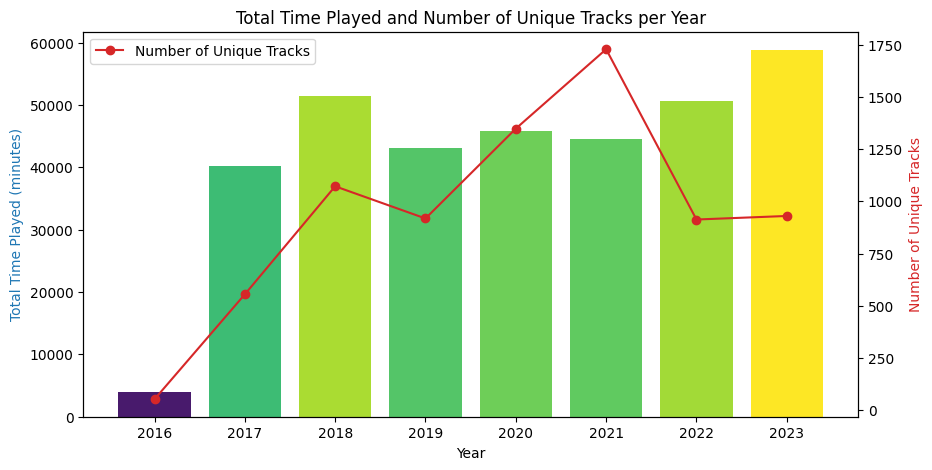

In [197]:
# Group by year and sum the ms_played in minutes
grouped_data = stream_df.groupby(['year'])['ms_played'].sum().div(60000)
grouped_counts = stream_df.groupby(['year'])['track_id'].nunique()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the sum of ms_played in minutes grouped by year with colored bars
bars = ax1.bar(grouped_data.index, grouped_data, color=plt.cm.viridis(grouped_data.values / grouped_data.max()), width=0.8)

# Set plot labels and title for the first y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Time Played (minutes)', color='tab:blue')
ax1.set_title('Total Time Played and Number of Unique Tracks per Year')

# Create a second y-axis for the counts
ax2 = ax1.twinx()
ax2.plot(grouped_counts.index, grouped_counts, color='tab:red', marker='o', label='Number of Unique Tracks')

# Set plot labels for the second y-axis
ax2.set_ylabel('Number of Unique Tracks', color='tab:red')

# Display the legend
ax2.legend(loc='upper left')

# Show the plot
plt.show()


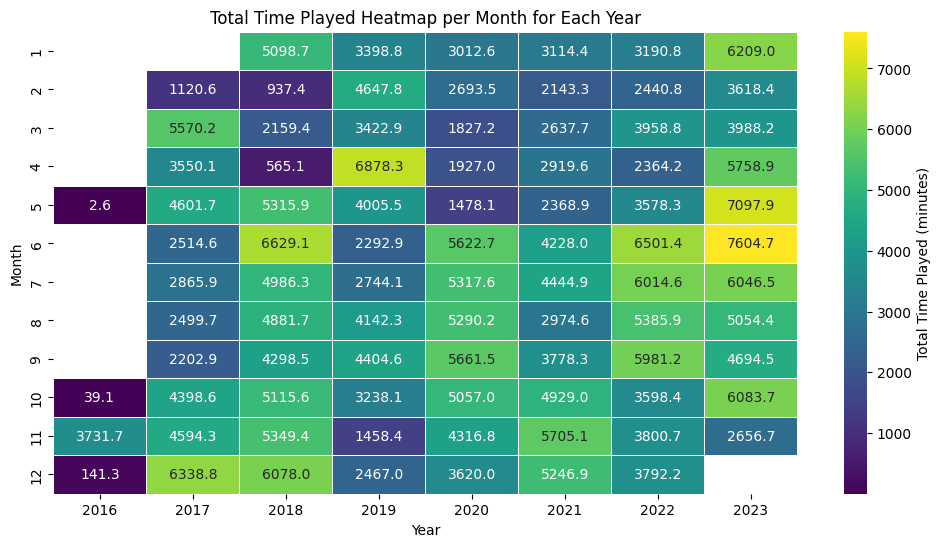

In [198]:
# Group by year and month and sum the ms_played in minutes
grouped_data_monthly = stream_df.groupby(['year', 'month'])['ms_played'].sum().div(60000)

# Reshape the data for plotting
pivot_data = grouped_data_monthly.unstack(level=0)

# Create a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap="viridis", annot=True, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Total Time Played (minutes)'})

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Total Time Played Heatmap per Month for Each Year')

# Show the plot
plt.show()


as we can see from the visualizations, [2018, 2023] are the top 2 year where I listened music on spotify the most and [2016, 2017] are the least. Note that the length of data for 2016 and 2023 are not a complete one-year long, since I started my spotify subscribtion on May 2016 and received the streaming history data on October 2023

## most listened artist and track per year

In [199]:
stream_df.columns

Index(['ts', 'platform', 'ms_played', 'conn_country', 'track_name',
       'artist_name', 'album_name', 'track_id', 'reason_start', 'reason_end',
       'shuffle', 'skipped', 'offline', 'incognito_mode', 'ts_local', 'year',
       'month', 'day', 'day_of_week', 'time_of_day'],
      dtype='object')

In [200]:
# find the top 5 most listened artists per year
top_artists = stream_df.groupby(['year', 'artist_name'])['ms_played'].sum().div(60000).reset_index()
top_artists = top_artists.rename(columns={'ts': 'year', 'ms_played': 'minutes'})
top_artists = top_artists.sort_values(['year', 'minutes'], ascending=[True, False])
top5_artists = top_artists.groupby('year').head(5)
top5_artists

,year,artist_name,minutes
29,2016,Ylvis,1011.990267
28,2016,Virtual Riot,835.094683
2,2016,Au5,358.598283
7,2016,Hyper Potions,355.384950
23,2016,The Chainsmokers,161.256083
127,2017,In Love With a Ghost,10910.546983
103,2017,Foster The People,1929.053783
204,2017,Pink Guy,1925.746667
85,2017,Ed Sheeran,1863.483133
34,2017,Aimer,1709.588150


In [201]:
# find the top 5 most listened tracks per year
top_tracks = stream_df.groupby(['year', 'track_id'])['ms_played'].sum().div(60000).reset_index()

# get the track_name using the track_id from the track_info_df
top_tracks = top_tracks.merge(track_info_df[['track_id', 'name', 'artistName']], on='track_id', how='left')
# create a new column with the track name and artist name
top_tracks['track'] = top_tracks['artistName'] + ' - ' + top_tracks['name']
# remove unnecessary columns
top_tracks = top_tracks.drop(columns=['track_id', 'name', 'artistName'])
# rename the columns
top_tracks = top_tracks.rename(columns={'ts': 'year', 'ms_played': 'minutes'})
# sort the values by year and minutes
top_tracks = top_tracks.sort_values(['year', 'minutes'], ascending=[True, False])
top5_tracks = top_tracks.groupby('year').head(5)
top5_tracks

,year,minutes,track
47,2016,834.998950,Virtual Riot - Time Stops
49,2016,479.813383,Ylvis - The Cabin
51,2016,355.384950,Hyper Potions - Unbreakable (feat. Danyka Nadeau)
40,2016,266.580850,Ylvis - Stonehenge
42,2016,265.596033,Ylvis - The Fox (What Does the Fox Say?)
595,2017,1929.053783,Foster The People - Pumped Up Kicks
131,2017,1449.877183,In Love With a Ghost - Interdimensional Portal...
500,2017,1227.475417,In Love With a Ghost - Crystal
80,2017,1218.392617,Fight Like Apes - I'm Beginning To Think You P...
427,2017,874.446717,In Love With a Ghost - Flowers


In [202]:
top_artists.columns

Index(['year', 'artist_name', 'minutes'], dtype='object')

In [203]:
# get the top 10 artist for each year
top10_artists = top_artists.groupby('year').head(10).reset_index(drop=True)

# create a pivot table and set year as the column and minutes as the values
top10_artists_pivot = top10_artists.pivot_table(index='artist_name', columns='year', values='minutes').round(2).reset_index()

# add 'total' column to pivot table except the 'artist_name' column
top10_artists_pivot['total appearance'] = top10_artists_pivot.iloc[:, 1:].count(axis = 1)
top10_artists_pivot['total minutes'] = top10_artists_pivot.iloc[:, 1:-1].sum(axis = 1)
top10_artists_pivot.fillna(0, inplace = True)

In [204]:
top10_artists_pivot.sort_values('total minutes', ascending=False).head(10)

year,artist_name,2016,2017,2018,2019,2020,2021,2022,2023,total appearance,total minutes
6,Bishop Briggs,0.0,0.00,7945.52,4358.45,5502.82,2539.33,2488.81,0.00,5,22834.93
22,In Love With a Ghost,0.0,10910.55,3422.96,1318.06,1932.91,2180.37,0.00,0.00,5,19764.85
48,Us The Duo,0.0,0.00,0.00,0.00,11927.04,4956.65,2681.68,0.00,3,19565.37
32,Orla Gartland,0.0,0.00,0.00,0.00,0.00,0.00,12528.82,7009.47,2,19538.29
55,dodie,0.0,0.00,0.00,0.00,0.00,0.00,7501.16,7583.35,2,15084.51
9,Daniela Andrade,0.0,0.00,0.00,0.00,6549.73,6131.10,0.00,619.12,3,13299.95
34,Pomplamoose,0.0,0.00,0.00,0.00,0.00,0.00,0.00,10775.14,1,10775.14
12,Darren Korb,0.0,0.00,0.00,0.00,1613.77,6099.71,0.00,0.00,2,7713.48
51,Wasia Project,0.0,0.00,0.00,0.00,0.00,0.00,4086.67,3322.06,2,7408.73
26,Lawrence,0.0,0.00,0.00,0.00,0.00,0.00,0.00,6502.85,1,6502.85


[Bishop Briggs](https://open.spotify.com/artist/0yb46jwm7gqbZXVXZQ8Z1e?si=EYY1B2NiSlGLXjou-ivirQ), [In Love With a Ghost](https://open.spotify.com/artist/21tDFddcOFDYmiobTcls2O?si=vd-9NN3MRXqC8n0WF0aGgQ) and [Us The Duo](https://open.spotify.com/artist/3QGKsAfhZdldQCLuLjk6zl?si=HogjwZsUSxWqIOKcdVQ_-Q) are the three artists that I regularly listened to, and two of them appeared 5 years in a row in my top 10 most listened artists.

In [205]:
# create a pivot table and set year as the column and minutes as the values
all_artists_pivot = top_artists.pivot_table(index='artist_name', columns='year', values='minutes').round(2).reset_index()

# add 'total' column to pivot table except the 'artist_name' column
all_artists_pivot['total appearance'] = all_artists_pivot.iloc[:, 1:].count(axis = 1)
all_artists_pivot['total minutes'] = all_artists_pivot.iloc[:, 1:-1].sum(axis = 1)
all_artists_pivot.fillna(0, inplace = True)

In [206]:
all_artists_pivot.sort_values(by=['total minutes', 'total appearance'], ascending=[False, False]).head(5)

year,artist_name,2016,2017,2018,2019,2020,2021,2022,2023,total appearance,total minutes
147,Bishop Briggs,0.0,0.00,7945.52,4358.45,5502.82,2539.33,2488.81,177.34,6,23012.27
1425,Us The Duo,0.0,0.00,0.00,0.00,11927.04,4956.65,2681.68,479.11,4,20044.48
569,In Love With a Ghost,0.0,10910.55,3422.96,1318.06,1932.91,2180.37,0.19,106.28,7,19871.32
999,Orla Gartland,0.0,0.00,0.00,0.00,0.00,0.00,12528.82,7009.47,2,19538.29
1543,dodie,0.0,0.00,0.00,0.00,0.00,0.00,7501.16,7583.35,2,15084.51


In [207]:
all_artists_pivot.sort_values(by=['total appearance', 'total minutes'], ascending=[False, False]).head(5)

year,artist_name,2016,2017,2018,2019,2020,2021,2022,2023,total appearance,total minutes
1493,Ylvis,1011.99,851.06,43.46,94.81,4.02,23.84,1.27,14.64,8,2045.09
554,Hyper Potions,355.38,354.18,15.20,960.08,2.97,8.84,0.70,12.01,8,1709.36
852,Maroon 5,132.46,530.42,16.49,61.31,3.39,25.17,21.14,39.33,8,829.71
853,Marshmello,107.77,280.69,10.65,28.01,1.61,5.83,5.47,0.07,8,440.10
569,In Love With a Ghost,0.00,10910.55,3422.96,1318.06,1932.91,2180.37,0.19,106.28,7,19871.32


Ylvis, Hyper Potions, Maroon 5 and Marshmello are the artists that I've been regularly listened to for 8 years in a row, though their music are not really my preference (as shown by the very low number of minutes I spent listening to these artists in most of the years), there were some moments where I enjoy their music.

But in terms of consistency, I think [In Love With a Ghost](https://open.spotify.com/artist/21tDFddcOFDYmiobTcls2O?si=vd-9NN3MRXqC8n0WF0aGgQ) is definitely one of my artists of choice when it comes to music/song that I will listen when I'm studying or walking around the city.

In [208]:
all_artists_pivot.sort_values(by=['total appearance', 'total minutes'], ascending=[True, False]).head(10)

year,artist_name,2016,2017,2018,2019,2020,2021,2022,2023,total appearance,total minutes
755,Lawrence,0.0,0.0,0.00,0.0,0.0,0.00,0.00,6502.85,1,6502.85
231,Chilli Beans.,0.0,0.0,0.00,0.0,0.0,0.00,6201.34,0.00,1,6201.34
1167,Scary Pockets,0.0,0.0,0.00,0.0,0.0,0.00,0.00,5765.28,1,5765.28
745,Lake Street Dive,0.0,0.0,0.00,0.0,0.0,0.00,0.00,966.40,1,966.40
1183,Shagabond,0.0,0.0,0.00,0.0,0.0,919.32,0.00,0.00,1,919.32
1384,Tomggg,0.0,0.0,752.76,0.0,0.0,0.00,0.00,0.00,1,752.76
840,Magaziine,0.0,0.0,0.00,0.0,0.0,0.00,0.00,625.82,1,625.82
812,Luke Bond,0.0,0.0,544.45,0.0,0.0,0.00,0.00,0.00,1,544.45
588,JUDY AND MARY,0.0,0.0,0.00,0.0,0.0,526.80,0.00,0.00,1,526.80
273,DEPAPEPE,0.0,492.1,0.00,0.0,0.0,0.00,0.00,0.00,1,492.10


[Chilli Beans.](https://open.spotify.com/artist/48apiuEaHdddhdRvfFjPB7?si=A8L2JD80TBuWtwlKsLwPCA) is another artist that I had a moment where I really like them and suddenly stopped listening to it

<BarContainer object of 7 artists>

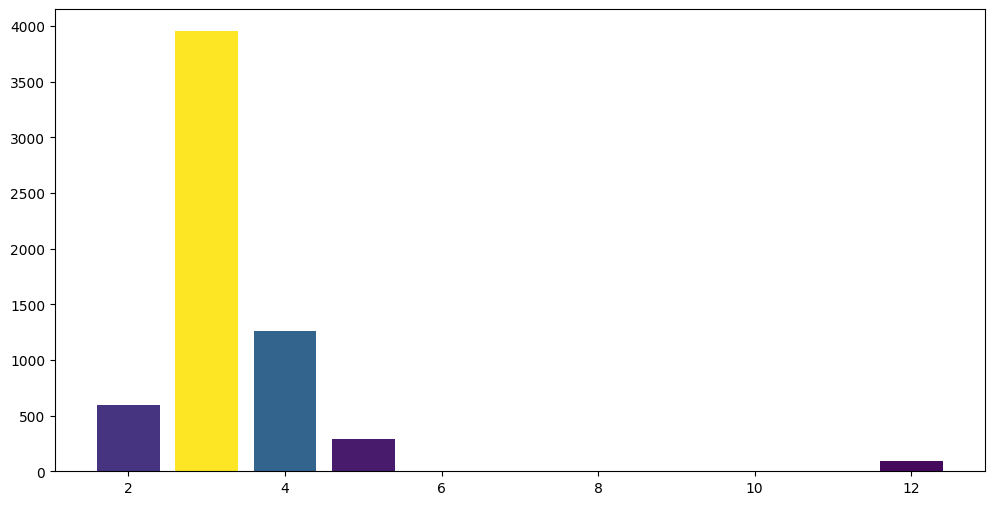

In [210]:
chilibeans = stream_df[stream_df['artist_name'] == 'Chilli Beans.'].groupby('month')['ms_played'].sum().div(60000)

plt.figure(figsize=(12, 6))
plt.bar(chilibeans.index, chilibeans, color=plt.cm.viridis(chilibeans.values / chilibeans.max()), width=0.8)


In [215]:
top2022_artists = stream_df[stream_df['year'] == 2022].groupby(['artist_name', stream_df['month']])['ms_played'].sum().div(60000).reset_index()
top2022_artists.rename(columns={'ms_played': 'minutes'}, inplace=True)


In [216]:
top2022_artists[top2022_artists['month'].isin([2,3,4,5,6])].sort_values(['month', 'minutes'], ascending=[True, False]).groupby('month').head(5)

,artist_name,month,minutes
677,Us The Duo,2,1519.882967
111,Chilli Beans.,2,599.430133
303,Junko Kamata,2,72.093867
818,softy,2,14.831000
507,Osaki,2,11.879533
112,Chilli Beans.,3,3953.975817
819,softy,3,2.791933
822,ticofaces,3,1.833333
796,l'Outlander,3,0.219217
113,Chilli Beans.,4,1262.103717


so I mostly listened to Chilli Beans. for the entire february 2022 and then gradually moved on to another artists.

In [217]:
# group by artist_name and count the number of unique track_id and total ms_played in minutes
artists_grouped = stream_df.groupby('artist_name').agg({'track_id': 'nunique', 'ms_played': 'sum'}).reset_index()
# rename the columns
artists_grouped = artists_grouped.rename(columns={'track_id': 'total tracks', 'ms_played': 'total minutes'})
artists_grouped['total minutes'] = artists_grouped['total minutes'].div(60000).round(2)


In [218]:
artists_grouped.sort_values(by=['total tracks', 'total minutes'], ascending=[False, False]).head(5)

,artist_name,total tracks,total minutes
1628,オルゴール ミドリ,121,1522.16
1425,Us The Duo,103,20044.49
273,DEPAPEPE,77,492.10
297,Daoko,74,2124.47
569,In Love With a Ghost,72,19871.32


In [219]:
artists_grouped.sort_values(by=['total minutes', 'total tracks'], ascending=[False, False]).head(5)

,artist_name,total tracks,total minutes
147,Bishop Briggs,63,23012.27
1425,Us The Duo,103,20044.49
569,In Love With a Ghost,72,19871.32
999,Orla Gartland,40,19538.29
1543,dodie,53,15084.51


### Question: is there any correlation between total tracks listened and total minutes listened?

#### number of tracks vs total minutes listened

In [220]:
correlation_coefficient, p_value = pearsonr(artists_grouped['total tracks'], artists_grouped['total minutes'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")

Pearson Correlation Coefficient: 0.6030591788878208
P-Value: 1.3621184928142136e-163


the result shows that there is statistically significant correlation between the number of tracks and total minutes listened from an artist.
note: though keep in mind this only measure the number of song and total minutes listened regardless how many time the I *tried* to play them.

#### number of tracks vs average minutes listened

In [221]:
# but first let's re-check the correlation analysis we did earlier, get total tracks and average ms_played per artists
artists_grouped_avg = stream_df.groupby('artist_name').agg({'track_id': 'nunique', 'ms_played': 'mean'}).reset_index()

In [222]:
artists_grouped_avg.rename(columns={'track_id': 'total tracks', 'ms_played': 'average minutes'}, inplace=True)

In [223]:
artists_grouped_avg['average minutes'] = artists_grouped_avg['average minutes'].div(60000).round(2)

In [224]:
correlation_coefficient, p_value = pearsonr(artists_grouped_avg['total tracks'], artists_grouped_avg['average minutes'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
print(f"P-Value: {p_value}")

Pearson Correlation Coefficient: 0.08867969106825857
P-Value: 0.00031555658816710653


contrast to what we seen in the earlier correlation analysis (number of tracks vs total minutes listened), I found that there is barely any correlation (or well, no correlation) between number of tracks listened to average minutes listened

## bar chart animation

The goal for this section is to visualize total stream per artists using [bar chart race](https://www.dexplo.org/bar_chart_race/) library.

First, transform the data into "year-month" format per row as we will visualize it monthly from the very first time I subscribed on spotify till the cut-off date of the data (which is November 2023)

In [225]:
artists_grouped_by_month = stream_df.groupby(['year', 'month', 'artist_name'])['ms_played'].sum().div(60000)
artists_grouped_by_month.rename_axis(['year', 'month', 'artist_name'], inplace=True)
artists_grouped_by_month = artists_grouped_by_month.reset_index()
artists_grouped_by_month.rename(columns={'ms_played': 'minutes'}, inplace=True)
artists_grouped_by_month['minutes'] = artists_grouped_by_month['minutes'].round(2)

In [226]:
artists_grouped_by_month.dtypes

year             int64
month            int64
artist_name     object
minutes        float64
dtype: object

In [227]:
# create year-month column where year and month are combined as a string and then convert it to datetime with month 2 digits
artists_grouped_by_month['year-month'] = artists_grouped_by_month['year'].astype(str) + '-' + artists_grouped_by_month['month'].astype(str).str.zfill(2)

In [228]:
# remove unnecessary columns
artists_grouped_by_month.drop(columns=['year', 'month'], inplace=True)

In [229]:
# create a pivot table with year-month as index, artist_name as columns and minutes as values
artists_grouped_by_month_pivot = artists_grouped_by_month.pivot_table(index='year-month', columns='artist_name', values='minutes').round(2)
artists_grouped_by_month_pivot.fillna(0, inplace=True)
# calculate the cumulative sum of the minutes for each artist
artists_grouped_by_month_pivot.iloc[:, 1:] = artists_grouped_by_month_pivot.iloc[:, 1:].cumsum(axis=0)

In [230]:
artists_grouped_by_month_pivot

artist_name,21univ.,36 Questions,3LAU,3OH!3,3R2,50 Cent,5054281243927,5argon,7!!,8 Graves,...,権太夫,石元 丈晴,石川 大樹,純白p,美波,羽山晃生,鈴木 光人,音田 雅則,麗奈,황혜영
year-month,,,,,,,,,,,,,,,,,,,,,
2016-05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2016-10,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2016-11,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2016-12,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2017-02,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2017-03,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2017-04,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2017-05,0.00,0.00,0.00,0.00,0.00,3.17,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2017-06,0.00,0.00,0.00,0.00,0.00,3.17,0.21,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00


In [ ]:
# install bar_chart_race v0.2.0 since the latest version has 'end_period_pause' parameter which allow the animation to pause at the end of each period
!pip install git+https://github.com/dexplo/bar_chart_race

In [231]:
# import bar-chart-race library
import bar_chart_race as bcr


In [232]:
# the bar chart animation will be saved as top_artists_by_month.mp4 in datasets folder
bcr.bar_chart_race(df = artists_grouped_by_month_pivot, 
                   n_bars = 10, # number of bars/artists to display
                   title = "Nazhif's Top Artists on Spotify (minutes)", 
                   filename='datasets/top_artists_by_month.mp4', 
                   fig_kwargs={'figsize': (9,16), 'dpi': 144}, # the ratio is 9:16 since the animation will be displayed on Instagram Story
                   bar_size=.75, 
                   bar_textposition='inside',
                   bar_texttemplate='{x:,.0f}', 
                   end_period_pause=100,
                   bar_label_font=9, 
                   tick_label_font=9,
                   period_label={'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'},
                   period_summary_func=lambda v, r: {'x': .98, 'y': .2, 's': f'Total Minutes: {v.sum():,.0f}', 'ha': 'right', 'size': 11}
                   )

C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_utils.py:111: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_bar_chart_race.py:232: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


In [234]:
# the bar chart animation will be saved as top_artists_by_month.mp4 in datasets folder
bcr.bar_chart_race(df = artists_grouped_by_month_pivot, 
                   n_bars = 10, # number of bars/artists to display
                   title = "Nazhif's Top Artists on Spotify (minutes)", 
                   filename='datasets/top_artists_by_month_h.mp4',
                   bar_size=.75, 
                   bar_textposition='inside',
                   bar_texttemplate='{x:,.0f}', 
                   end_period_pause=100,
                   bar_label_font=9, 
                   tick_label_font=9,
                   period_label={'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'},
                   period_summary_func=lambda v, r: {'x': .98, 'y': .2, 's': f'Total Minutes: {v.sum():,.0f}', 'ha': 'right', 'size': 11}
                   )

C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_utils.py:111: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_bar_chart_race.py:232: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


In [233]:
# the bar chart animation will be shown in the notebook
bcr.bar_chart_race(df = artists_grouped_by_month_pivot, 
                   n_bars = 10, 
                   title = "Nazhif's Top Artists on Spotify (minutes)",
                   bar_size=.75, 
                   bar_textposition='inside',
                   bar_texttemplate='{x:,.0f}', 
                   end_period_pause=100,
                   bar_label_font=9, 
                   tick_label_font=9,
                   period_label={'x': .98, 'y': .3, 'ha': 'right', 'va': 'center'},
                   period_summary_func=lambda v, r: {'x': .98, 'y': .2, 's': f'Total Minutes: {v.sum():,.0f}', 'ha': 'right', 'size': 11}
                   )

C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_utils.py:111: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_values.iloc[:, 0] = df_values.iloc[:, 0].fillna(method='ffill')
C:\Users\Kim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bar_chart_race\_bar_chart_race.py:232: UserWarning: Some of your columns never make an appearance in the animation. To reduce color repetition, set `filter_column_colors` to `True`
  warnings.warn("Some of your columns never make an appearance in the animation. "


## analyzing listening sessions

In [286]:
# we need to get the song duration from track_info_df
stream_df = stream_df.merge(track_info_df[['track_id', 'duration_ms']], on='track_id', how='left')

In [288]:
stream_df.isna().sum()

ts                   0
platform             0
ms_played            0
track_name           0
artist_name          0
album_name           0
track_id             0
reason_start         0
reason_end       20538
shuffle              0
skipped         105421
offline              0
duration_ms          0
dtype: int64

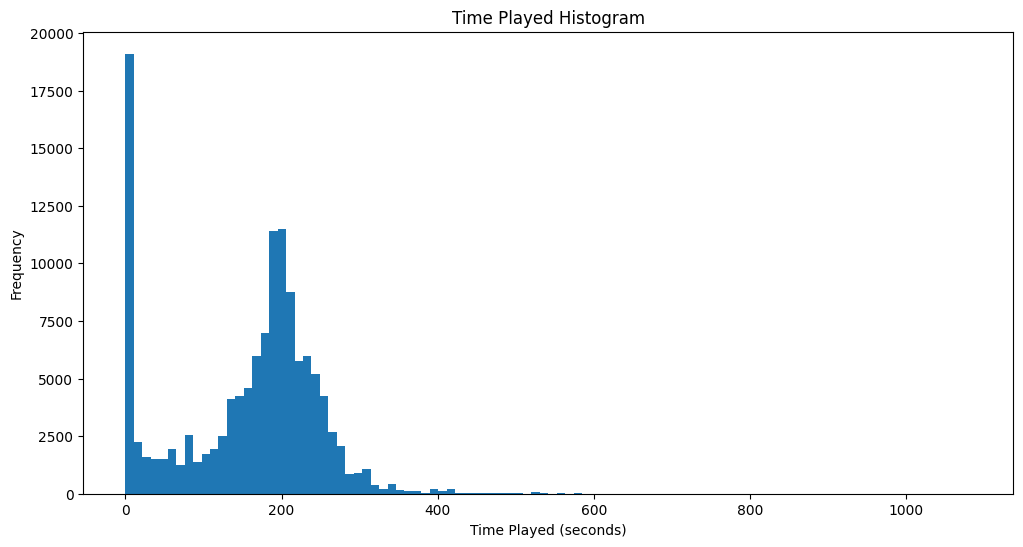

In [289]:
# plot histogram of ms_played in seconds
plt.figure(figsize=(12, 6))
plt.hist(stream_df['ms_played'].div(1000), bins=100, color='tab:blue')
plt.xlabel('Time Played (seconds)')
plt.ylabel('Frequency')
plt.title('Time Played Histogram')
plt.show()

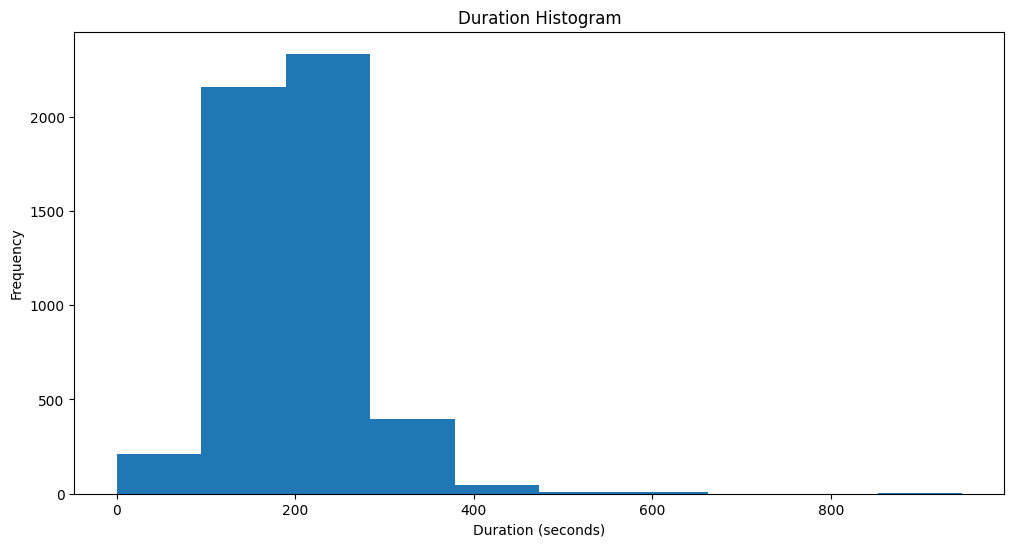

In [298]:
# plot histogram of duration_ms in seconds with only unique track_id and filter-out the songs that are longer than 1000 seconds
plt.figure(figsize=(12, 6))
plt.hist(stream_df[(stream_df['track_id'].duplicated() == False) & (stream_df['duration_ms'] < 1000000)]['duration_ms'].div(1000), bins=10, color='tab:blue')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Duration Histogram')
plt.show()

In [324]:
# number of rows / listening session that are less than its duration, and the percentage of it
print('number of rows/session shorter than its duration: ' + str(stream_df[stream_df['ms_played'] < stream_df['duration_ms']].shape[0]))
print(str((stream_df[stream_df['ms_played'] < stream_df['duration_ms']].shape[0] / stream_df.shape[0] * 100).__round__(2)) + '%')

number of rows/session shorter than its duration: 44209
34.55%


In [335]:
stream_df[(stream_df['track_id'].duplicated() == False) & (stream_df['duration_ms'] < 1000000) & (stream_df['ms_played'] < stream_df['duration_ms'])]['ms_played'].div(1000).value_counts(bins=10, sort=False)

(-0.58, 57.86]        1756
(57.86, 115.719]       254
(115.719, 173.579]     410
(173.579, 231.438]     239
(231.438, 289.298]      82
(289.298, 347.158]      28
(347.158, 405.017]       5
(405.017, 462.877]       0
(462.877, 520.736]       0
(520.736, 578.596]       1
Name: count, dtype: int64

as we can see from the distribution of ms_played and duration_ms (both are displayed in seconds), 34% of the rows(listening/streaming sessions) are 0s or less than the track's duration, which is pretty interesting to explore.

In [319]:
stream_df.columns

Index(['ts', 'platform', 'ms_played', 'track_name', 'artist_name',
       'album_name', 'track_id', 'reason_start', 'reason_end', 'shuffle',
       'skipped', 'offline', 'duration_ms'],
      dtype='object')

In [330]:
stream_df[['reason_start', 'reason_end', 'shuffle', 'skipped']].isna().sum()

reason_start         0
reason_end       20538
shuffle              0
skipped         105421
dtype: int64

In [329]:
# display unique value of reason_start, reason_end, shuffle and skipped columns
print(stream_df['reason_start'].unique())
print(stream_df['reason_end'].unique())
print(stream_df['shuffle'].unique())
print(stream_df['skipped'].unique())

['clickrow' 'fwdbtn' 'appload' 'trackdone' 'backbtn' 'playbtn' 'remote'
 'trackerror']
['fwdbtn' 'endplay' 'unexpected-exit-while-paused' 'logout' 'trackdone'
 nan 'backbtn' 'remote' 'unexpected-exit' 'trackerror' 'unknown']
[False  True]
[nan '0.0' '1.0' 'False' 'True']


In [353]:
# conditions 
incomplete = (stream_df['ms_played'] < stream_df['duration_ms'])
complete = (stream_df['ms_played'] == stream_df['duration_ms'])
less_than_minute = (stream_df['ms_played'] <= 60000)
longer_than_duration = (stream_df['ms_played'] > stream_df['duration_ms'])

In [354]:
display(stream_df[less_than_minute]['reason_start'].value_counts(dropna=False))
display(stream_df[~less_than_minute & incomplete]['reason_start'].value_counts(dropna=False))
display(stream_df[complete]['reason_start'].value_counts(dropna=False))
display(stream_df[longer_than_duration]['reason_start'].value_counts(dropna=False))

reason_start
fwdbtn        9951
trackdone     6764
backbtn       5416
clickrow      2274
appload       1938
remote         315
playbtn        204
trackerror     153
Name: count, dtype: int64

reason_start
trackdone     14691
appload        1819
fwdbtn          909
clickrow        783
backbtn         327
remote          292
playbtn         110
trackerror       31
Name: count, dtype: int64

reason_start
trackdone     74302
clickrow       2652
fwdbtn         2634
backbtn        1502
playbtn         309
trackerror      161
appload         133
remote           37
Name: count, dtype: int64

reason_start
trackdone     1281
appload        255
clickrow       200
fwdbtn         126
backbtn         98
remote          45
playbtn         12
trackerror       5
Name: count, dtype: int64

In [358]:
display(stream_df[less_than_minute]['reason_end'].value_counts(dropna=False))
display(stream_df[~less_than_minute & incomplete]['reason_end'].value_counts(dropna=False))
display(stream_df[complete]['reason_end'].value_counts(dropna=False))
display(stream_df[longer_than_duration]['reason_end'].value_counts(dropna=False))

reason_end
fwdbtn                          9579
NaN                             5382
backbtn                         4851
endplay                         2771
trackdone                       1995
logout                          1701
remote                           414
unexpected-exit-while-paused     198
trackerror                        63
unexpected-exit                   39
unknown                           22
Name: count, dtype: int64

reason_end
trackdone                       10415
logout                           3047
NaN                              1790
fwdbtn                           1408
endplay                           903
remote                            647
backbtn                           382
unexpected-exit-while-paused      311
unknown                            32
unexpected-exit                    27
Name: count, dtype: int64

reason_end
trackdone    68073
NaN          13632
endplay         24
fwdbtn           1
Name: count, dtype: int64

reason_end
trackdone                       1509
NaN                              404
logout                            39
fwdbtn                            37
endplay                           16
backbtn                            7
remote                             6
unexpected-exit-while-paused       4
Name: count, dtype: int64

In [359]:
display(stream_df[less_than_minute]['shuffle'].value_counts(dropna=False))
display(stream_df[~less_than_minute & incomplete]['shuffle'].value_counts(dropna=False))
display(stream_df[complete]['shuffle'].value_counts(dropna=False))
display(stream_df[longer_than_duration]['shuffle'].value_counts(dropna=False))

shuffle
True     15522
False    11493
Name: count, dtype: int64

shuffle
True     11383
False     7579
Name: count, dtype: int64

shuffle
True     49515
False    32215
Name: count, dtype: int64

shuffle
True     1031
False     991
Name: count, dtype: int64

In [360]:
display(stream_df[less_than_minute]['skipped'].value_counts(dropna=False))
display(stream_df[~less_than_minute & incomplete]['skipped'].value_counts(dropna=False))
display(stream_df[complete]['skipped'].value_counts(dropna=False))
display(stream_df[longer_than_duration]['skipped'].value_counts(dropna=False))

skipped
NaN      23978
True      1630
1.0        712
False      482
0.0        213
Name: count, dtype: int64

skipped
NaN      17549
False      658
True       316
0.0        306
1.0        133
Name: count, dtype: int64

skipped
NaN      63814
False    14875
0.0       3029
True         8
1.0          4
Name: count, dtype: int64

skipped
NaN      1643
False     267
0.0        98
True       12
1.0         2
Name: count, dtype: int64